In [32]:
!pip install tensorflow

In [33]:
import tensorflow as tf
import tensorflow_probability as tfp


class RBM(tf.keras.layers.Layer):
    def __init__(self, number_hidden_units=10, number_visible_units=None,
                 learning_rate=0.1, cd_steps=1):
        super().__init__()
        self.number_hidden_units = number_hidden_units
        self.number_visible_units = number_visible_units
        self.learning_rate = learning_rate
        self.cd_steps = cd_steps

    def build(self, input_shape):

        if not self.number_visible_units:
            self.number_visible_units = input_shape[-1]

        self.hb = self.add_weight(shape=(self.number_hidden_units, ),
                                  initializer='random_normal',
                                  trainable=True)
        self.vb = self.add_weight(shape=(self.number_visible_units, ),
                                  initializer='random_normal',
                                  trainable=True)
        self.w_rec = self.add_weight(shape=(self.number_visible_units,
                                     self.number_hidden_units),
                                     initializer='random_normal',
                                     trainable=True)
        self.w_gen = self.add_weight(shape=(self.number_hidden_units,
                                     self.number_visible_units),
                                     initializer='random_normal',
                                     trainable=True)

    def call(self, inputs):
        return tf.sigmoid(tf.add(tf.matmul(inputs, self.w_rec), self.hb))

    def free_energy(self, x):
        return -tf.tensordot(x, self.vb, 1)\
               - tf.reduce_sum(
                   tf.math.log(
                       1+tf.math.exp(
                           tf.add(
                               tf.matmul(x, self.w_rec), self.hb))), 1)

    def free_energy_reverse(self, x):
        return -tf.tensordot(x, self.hb, 1)\
               - tf.reduce_sum(
                   tf.math.log(
                       1+tf.math.exp(
                           tf.add(
                               tf.matmul(x, self.w_gen), self.vb))), 1)

    def forward(self, x):
        return tf.sigmoid(tf.add(tf.matmul(x, self.w_rec), self.hb))

    def sample_h(self, x):
        u_sample = tfp.distributions.Uniform().sample((x.shape[1],
                                                       self.hb.shape[-1]))
        return tf.cast(self.forward(x) > u_sample, tf.float32)

    def reverse(self, x):
        return tf.sigmoid(tf.add(tf.matmul(x, self.w_gen), self.vb))

    def sample_v(self, x):
        u_sample = tfp.distributions.Uniform().sample((x.shape[1],
                                                       self.vb.shape[-1]))
        return tf.cast(self.reverse(x) > u_sample, tf.float32)

    def reverse_gibbs(self, x):
        return self.sample_h(self.sample_v(x))

    def forward_gibbs(self, x):
        return self.sample_v(self.sample_h(x))

    def wake_update(self, x):
        with tf.GradientTape(watch_accessed_variables=False) as g:
            h_sample = self.sample_h(x)
            for _ in range(self.cd_steps):
                v_sample = self.sample_v(h_sample)
                h_sample = self.sample_h(v_sample)
            g.watch(self.w_gen)
            g.watch(self.vb)
            cost = tf.reduce_mean(self.free_energy(x)) - tf.reduce_mean(
                self.free_energy_reverse(h_sample))
        w_grad, vb_grad = g.gradient(cost, [self.w_gen, self.vb])

        self.w_gen.assign_sub(self.learning_rate * w_grad)
        self.vb.assign_sub(self.learning_rate * vb_grad)

        return self.reconstruction_cost(x).numpy()

    def sleep_update(self, x):
        with tf.GradientTape(watch_accessed_variables=False) as g:
            v_sample = self.sample_v(x)
            for _ in range(self.cd_steps):
                h_sample = self.sample_h(v_sample)
                v_sample = self.sample_v(h_sample)
            g.watch(self.w_rec)
            g.watch(self.hb)
            cost = tf.reduce_mean(self.free_energy_reverse(x)) - \
                tf.reduce_mean(self.free_energy(v_sample))
        w_grad, hb_grad = g.gradient(cost, [self.w_rec, self.hb])

        self.w_rec.assign_sub(self.learning_rate * w_grad)
        self.hb.assign_sub(self.learning_rate * hb_grad)

        return self.reconstruction_cost_reverse(x).numpy()

    def cd_update(self, x):
        with tf.GradientTape(watch_accessed_variables=False) as g:

            h_sample = self.sample_h(x)
            for _ in range(self.cd_steps):
                v_sample = tf.constant(self.sample_v(h_sample))
                h_sample = self.sample_h(v_sample)

            g.watch(self.w_rec)
            g.watch(self.hb)
            g.watch(self.vb)
            cost = tf.reduce_mean(self.free_energy(x)) -\
                tf.reduce_mean(self.free_energy(v_sample))

        w_grad, hb_grad, vb_grad = g.gradient(cost,
                                              [self.w_rec, self.hb, self.vb])

        self.w_rec.assign_sub(self.learning_rate * w_grad)
        self.w_gen = tf.Variable(tf.transpose(self.w_rec))  # force tieing
        self.hb.assign_sub(self.learning_rate * hb_grad)
        self.vb.assign_sub(self.learning_rate * vb_grad)

        return self.reconstruction_cost(x).numpy()

    def reconstruction_cost(self, x):
        return tf.reduce_mean(
            tf.reduce_sum(
                tf.math.add(
                            tf.math.multiply(x,
                                             tf.math.log(
                                                 self.reverse(
                                                     self.forward(x)))),
                            tf.math.multiply(tf.math.subtract(1, x),
                                             tf.math.log(
                                  tf.math.subtract(1, self.reverse(
                                                      self.forward(x)))))
                            ), 1),)

    def reconstruction_cost_reverse(self, x):
        return tf.reduce_mean(
            tf.reduce_sum(
                tf.math.add(
                            tf.math.multiply(x,
                                             tf.math.log(
                                                 self.forward(
                                                     self.reverse(x)))),
                            tf.math.multiply(
                                             tf.math.subtract(1, x),
                                             tf.math.log(
                                                 tf.math.subtract(1, self.forward(self.reverse(x)))))
                            ), 1),)

In [34]:
!pip install tensorflow_datasets

In [35]:
import tensorflow_datasets as tfds

mnist_builder = tfds.builder("mnist")
mnist_builder.download_and_prepare()

mnist_train = mnist_builder.as_dataset(split="train")

In [36]:
from functools import partial

def flatten_image(x, label=False):
    if label:
        return (tf.divide(tf.dtypes.cast(tf.reshape(x["image"], (1,28*28)), tf.float32), 256.0) , x["label"])
    else:
        return (tf.divide(tf.dtypes.cast(tf.reshape(x["image"], (1,28*28)), tf.float32), 256.0))

In [37]:
rbm = RBM(500)
rbm.build([784])
num_epochs=100

def train_rbm(rbm=None, data=mnist_train, map_fn=flatten_image, num_epochs=100, tolerance=None, batch_size=32, shuffle_buffer=1024):

        last_cost = None

        for epoch in range(num_epochs):
            cost = 0.0
            count = 0.0

            for datapoints in data.map(map_fn).shuffle(shuffle_buffer).batch(batch_size):
                cost += rbm.cd_update(datapoints)
                count += 1.0

            cost /= count
            print("epoch: {}, cost: {}".format(epoch, cost))

            if last_cost is not None and abs(last_cost-cost) <= tolerance:
                break
            last_cost = cost

        return rbm

rbm = train_rbm(rbm, mnist_train, partial(flatten_image, label=False), 100, 1e-3, 2000)


epoch: 0, cost: -0.5063009828329086
epoch: 1, cost: -0.3463424026966095
epoch: 2, cost: -0.30127624968687694
epoch: 3, cost: -0.2822328875462214
epoch: 4, cost: -0.27215992907683056
epoch: 5, cost: -0.26623515486717225
epoch: 6, cost: -0.26229428152243295
epoch: 7, cost: -0.2592356413602829
epoch: 8, cost: -0.25738959610462187
epoch: 9, cost: -0.25600449244181317
epoch: 10, cost: -0.2547249267498652
epoch: 11, cost: -0.25348155399163563
epoch: 12, cost: -0.2526167427500089


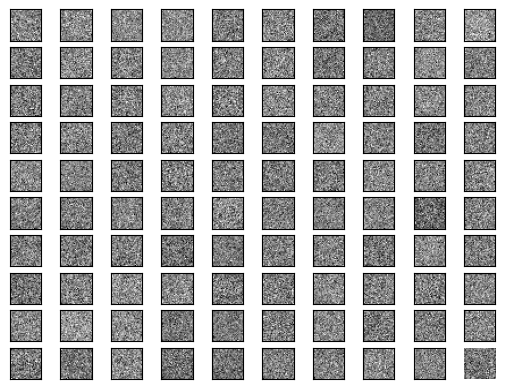

In [38]:
import matplotlib.pyplot as plt

fig, axarr = plt.subplots(10,10)
plt.axis('off')

for i in range(10):
    for j in range(10):
        fig.axes[i*10+j].get_xaxis().set_visible(False)
        fig.axes[i*10+j].get_yaxis().set_visible(False)
        axarr[i,j].imshow(rbm.w_rec.numpy()[:,i*10+j].reshape(28,28), cmap=plt.get_cmap("gray"))

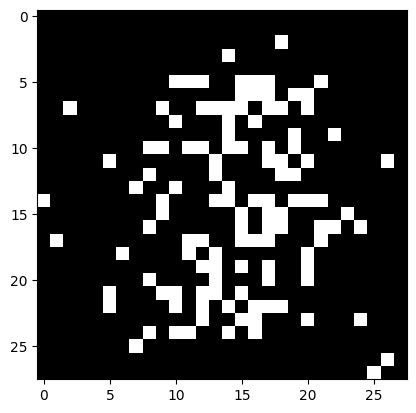

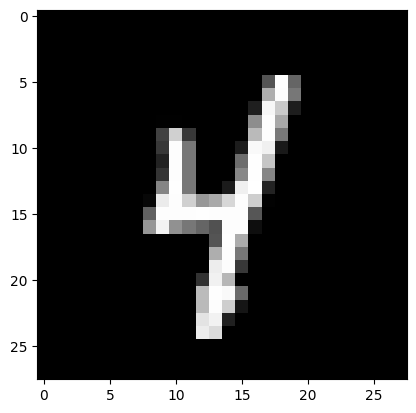

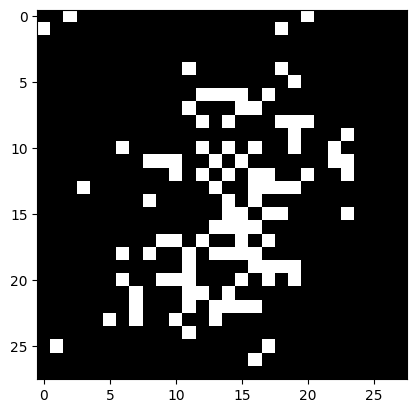

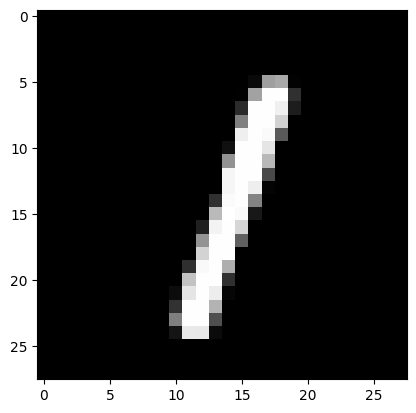

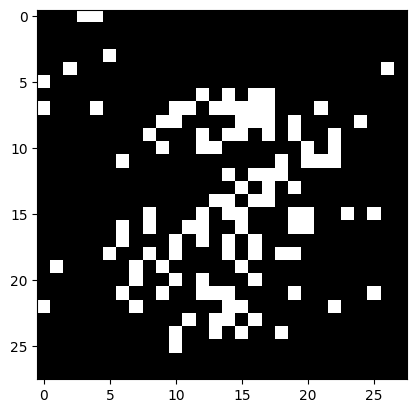

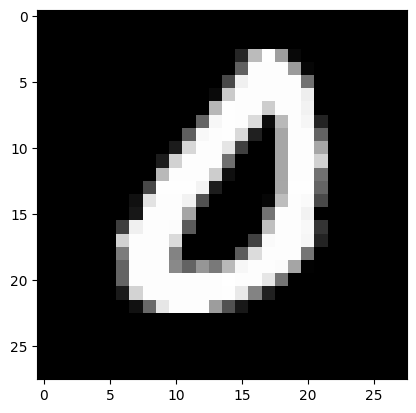

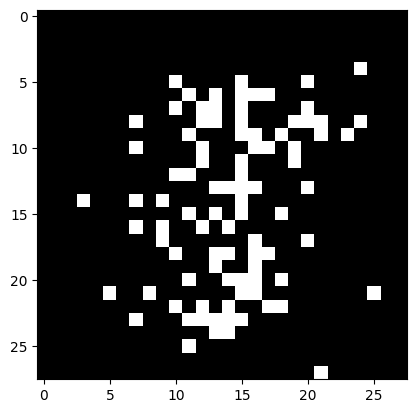

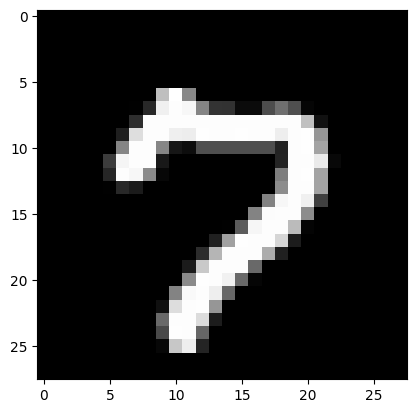

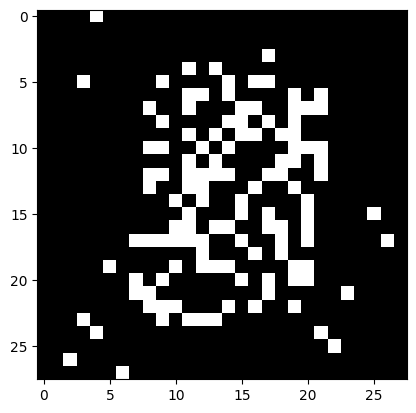

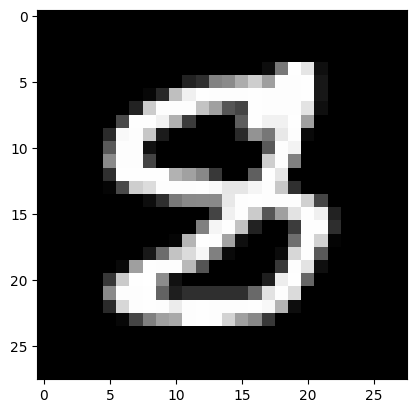

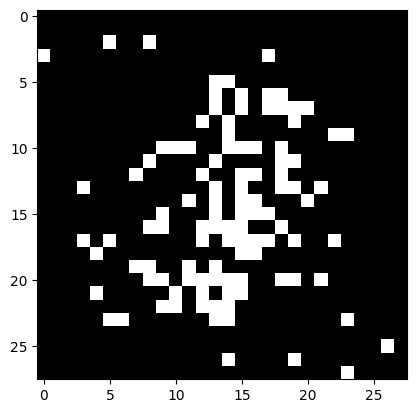

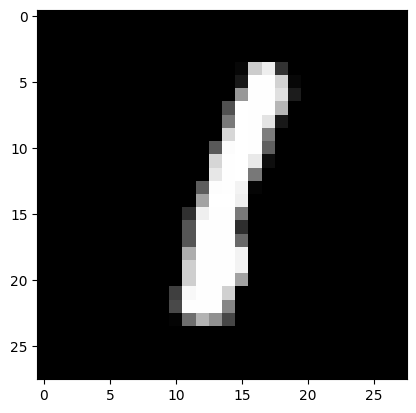

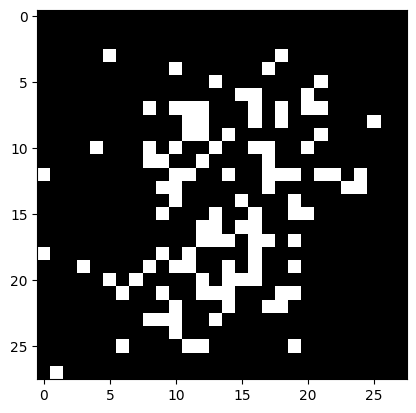

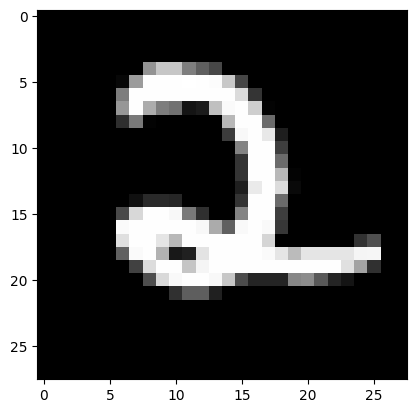

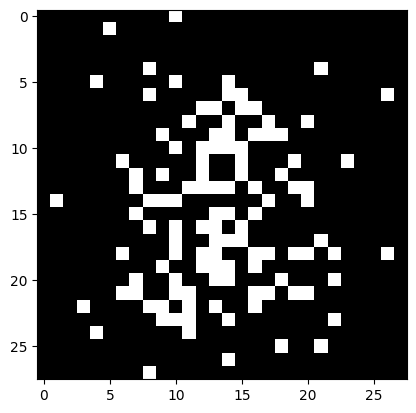

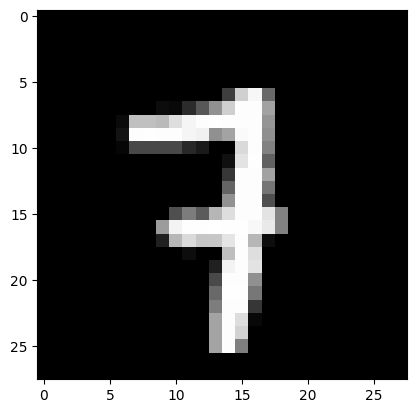

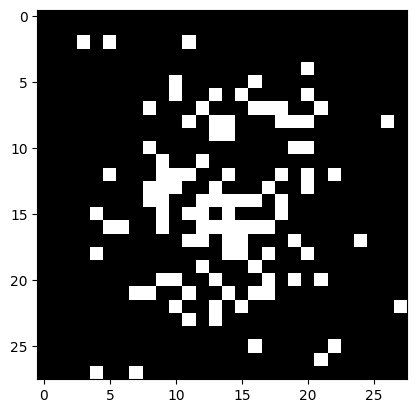

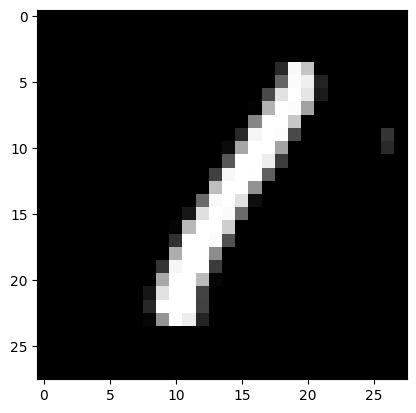

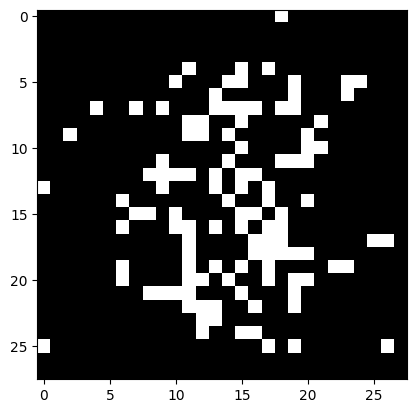

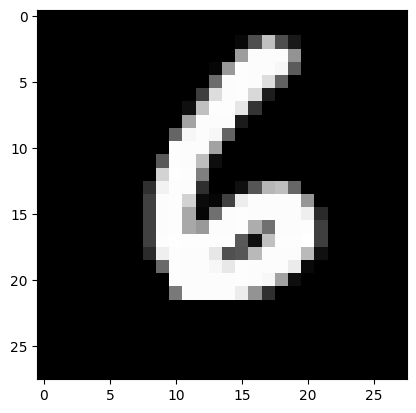

In [42]:
import numpy as np

i=0
for image in mnist_train.map(flatten_image).batch(1).take(10):
    plt.figure(i)
    plt.imshow(rbm.forward_gibbs(image).numpy().reshape(28,28).astype(np.float32),
               cmap=plt.get_cmap("gray"))
    i+=1
    plt.figure(i)
    plt.imshow(image.numpy().reshape(28,28).astype(np.float32), cmap=plt.get_cmap("gray"))
    i+=1